In [34]:
import torch

In [35]:
#Connecting Google Colab with Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
#Check for GPU
gpu = torch.cuda.is_available()
device = 'cuda' if gpu == True else 'cpu'
print('Using device:', device)

Using device: cuda


In [37]:
#Directories path
train_dir = "/content/drive/MyDrive/Oranges Dataset/Train"
test_dir = "/content/drive/MyDrive/Oranges Dataset/Test"

In [38]:
from torchvision import transforms

# Image transformations
transforms = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ])

In [39]:
from torchvision import datasets
from torch.utils.data import DataLoader

training_data = datasets.ImageFolder(root = train_dir, transform = transforms)
testing_data = datasets.ImageFolder(root = test_dir, transform = transforms)



train_loader = DataLoader(training_data, batch_size=32, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=32, shuffle=True)




Training set size:  321
Test set size:  80


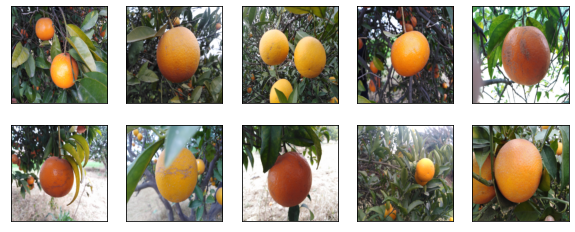

In [40]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os

def imshow(img):
    #img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
# obtain one batch of training images
data_iter = iter(train_loader)
images, lbls = data_iter.next()
images = images.numpy() # convert images to numpy for display
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    label = lbls[idx]
    #ax.set_title(classes[label])
    #ax.set_title(classes[lbls[idx]])
print('Training set size: ', len(training_data))
print('Test set size: ', len(testing_data))


In [41]:
# Iterate through the dataloader once
train_iter = iter(train_loader)
features, labels = next(train_iter)
features.shape, labels.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [42]:
#Loading in a pre-trained model
from torchvision import models
model = models.googlenet(pretrained=True)

In [43]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [44]:
import torch.nn as nn
n_classes = 4
# add on our own custom classifier
model.fc = nn.Sequential(
                      nn.Linear(1024, 500), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(500, n_classes),                   
                      nn.LogSoftmax(dim=1))

In [45]:
model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [46]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

6,114,408 total parameters.
514,504 training parameters.


In [47]:
# Move to gpu
model = model.to(device)
# Distribute across 2 gpus
model = nn.DataParallel(model)
print(device)

cuda


In [48]:
from torch import optim

# Loss and optimizer
criteration = nn.NLLLoss()
criteration = criteration.to(device)
optimizer = optim.Adam(model.parameters())

In [49]:
total_step = len(train_loader)
loss_list = []
acc_list = []
n_epochs = 15
for epoch in range(n_epochs):
  for i, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    targets = targets.to(device)
    # Generate predictions
    outputs = model(images)
    outputs = outputs.to(device)
    # Calculate loss
    loss = criteration(outputs, targets)
    loss_list.append(loss.item())
    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    # Backpropagation
    loss.backward()
    # Update model parameters
    optimizer.step()
    
    # Track the accuracy
    total = targets.size(0)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == targets).sum().item()
    acc_list.append(correct / total)
    print("Training")
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, n_epochs, i + 1, total_step, loss.item(),(correct / total) * 100))


Training
Epoch [1/15], Step [1/11], Loss: 1.3962, Accuracy: 28.12%
Training
Epoch [1/15], Step [2/11], Loss: 1.3898, Accuracy: 21.88%
Training
Epoch [1/15], Step [3/11], Loss: 1.3364, Accuracy: 50.00%
Training
Epoch [1/15], Step [4/11], Loss: 1.5247, Accuracy: 9.38%
Training
Epoch [1/15], Step [5/11], Loss: 1.3624, Accuracy: 46.88%
Training
Epoch [1/15], Step [6/11], Loss: 1.2270, Accuracy: 37.50%
Training
Epoch [1/15], Step [7/11], Loss: 1.3270, Accuracy: 21.88%
Training
Epoch [1/15], Step [8/11], Loss: 1.2293, Accuracy: 53.12%
Training
Epoch [1/15], Step [9/11], Loss: 1.1546, Accuracy: 46.88%
Training
Epoch [1/15], Step [10/11], Loss: 1.1059, Accuracy: 53.12%
Training
Epoch [1/15], Step [11/11], Loss: 1.6623, Accuracy: 0.00%
Training
Epoch [2/15], Step [1/11], Loss: 1.0347, Accuracy: 65.62%
Training
Epoch [2/15], Step [2/11], Loss: 1.4765, Accuracy: 37.50%
Training
Epoch [2/15], Step [3/11], Loss: 1.1876, Accuracy: 50.00%
Training
Epoch [2/15], Step [4/11], Loss: 1.1324, Accuracy: 43

In [50]:

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images=images.cuda()
        labels=labels.cuda()
        outputs = model(images).cuda()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy#: {} '.format((correct / total) * 100))

Test Accuracy#: 83.75 
